# K-Nearest Neighbours and the Curse of Dimensionality

## Introduction

This tutorial explores how the K-Nearest Neighbours (KNN) algorithm behaves on a simple two-dimensional dataset and how its performance changes when many irrelevant features are added. Using visualisations and controlled experiments, the goal is to build an intuition for why distance-based methods struggle in high-dimensional spaces, a phenomenon often referred to as the curse of dimensionality.

## KNN intuition

KNN is a non-parametric classifier that assigns a label to a new point by looking at the labels of its k closest neighbours in the training set, usually measured with Euclidean distance. Because the decision is based purely on local neighbourhoods, KNN can represent complex, non-linear decision boundaries, but it is also highly sensitive to the choice of k, the scaling of features, and the geometry of the underlying feature space.


In this tutorial, a K-Nearest Neighbours (KNN) classifier is applied to the `make_moons` dataset to explore how distance-based learning behaves as the dimensionality of the feature space increases. The goal is to show, through experiments and visualisations, how the curse of dimensionality affects KNN and how techniques such as feature scaling and dimensionality reduction can mitigate these issues.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

plt.style.use("seaborn-v0_8-colorblind")  # colour-blind friendly style


## Helper function for visualisation

In [ ]:
def plot_decision_boundary(model, X, y, title="Decision boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    cmap_bg = ListedColormap(["#fde725", "#440154"])
    cmap_pts = ListedColormap(["#21918c", "#440154"])

    plt.figure(figsize=(5, 4))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_bg)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_pts, edgecolor="k", s=30)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.tight_layout()




To make the behaviour of KNN easier to understand, a helper function is defined to plot decision boundaries for any 2D classifier. It creates a dense grid over the feature space, uses the trained model to predict labels on that grid, and overlays the resulting regions with the original data points.


## **make_moons dataset**
## Dataset summary

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First 5 samples of X:\n", X[:5])
print("First 5 labels of y:", y[:5])


X shape: (500, 2)
y shape: (500,)
First 5 samples of X:
 [[ 0.83094847 -0.29654552]
 [ 1.08838668  0.8996934 ]
 [ 1.13563371 -0.46293467]
 [-0.08227739  1.05971844]
 [ 0.44304745  1.4189766 ]]
First 5 labels of y: [1 0 1 0 0]


The generated feature matrix `X` has shape `(500, 2)`, so there are 500 observations and exactly two numerical features per observation. The target vector `y` has shape `(500,)`, providing one binary class label for each of the 500 samples. For example, the first few feature vectors `[[0.8309, -0.2965], [1.0884, 0.8997], [1.1356, -0.4629], [-0.0823, 1.0597], [0.4430, 1.4190]]` correspond to labels `[1, 0, 1, 0, 0]`, confirming that the task is a two-class classification problem in a two-dimensional space.


### Visual pattern of the classes

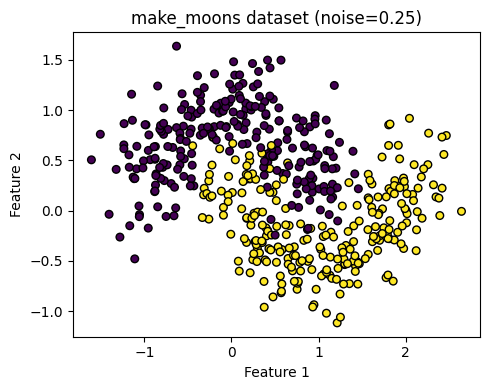

In [ ]:
plt.figure(figsize=(5, 4))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis", edgecolor="k", s=30)
plt.title("make_moons dataset (noise=0.25)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()


The scatter plot of the two features shows two interleaving clusters that resemble noisy half-moon shapes, with each colour indicating one of the two classes.Points of different classes are close to each other along the curved boundary, which makes the task non-linearly separable and therefore well suited for studying how KNN adapts its decision boundary to local neighbourhood structure.


## Train–test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (350, 2) (350,)
Test shape: (150, 2) (150,)


The dataset is divided into 350 training samples and 150 test samples, each still represented by two features.Stratified sampling is used so that the class proportions in the training and test sets match the original dataset, which leads to a more reliable estimate of generalisation performance for the KNN classifier.


### Baseline KNN performance

In [ ]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)

y_pred = knn_5.predict(X_test)
baseline_acc = accuracy_score(y_test, y_pred)
print(f"Baseline KNN (k=5) accuracy: {baseline_acc:.3f}")


Baseline KNN (k=5) accuracy: 0.953




A baseline KNN classifier with `k = 5` correctly classifies 95.3% of the test samples on the `make_moons` dataset (`accuracy = 0.953`).This high accuracy suggests that using a small neighbourhood already captures much of the curved class structure, while still averaging over enough neighbours to be relatively robust to the injected noise.


## Effect of the number of neighbours

**Decision boundary for k = 5**

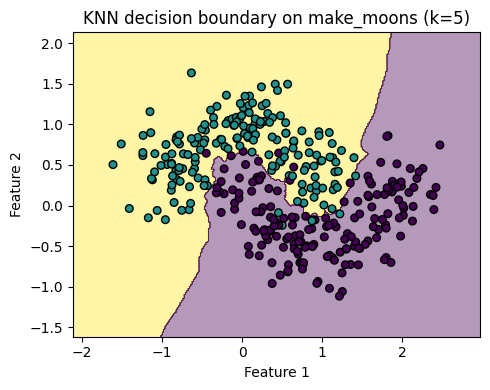

In [ ]:
plot_decision_boundary(
    knn_5,
    X_train,
    y_train,
    title="KNN decision boundary on make_moons (k=5)"
)
plt.show()


**explore different k values**

k values: [1, 3, 5, 11, 21, 51]
Train accuracies: [1.    0.957 0.96  0.96  0.96  0.934]
Test accuracies: [0.933 0.953 0.953 0.947 0.96  0.947]


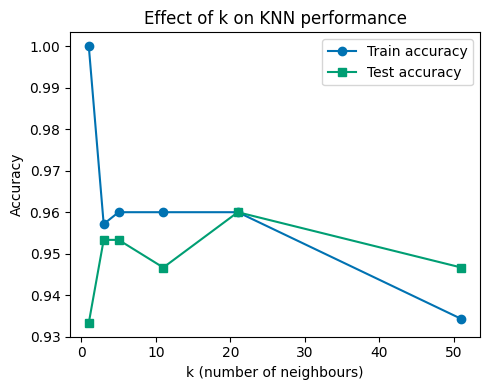

In [ ]:
k_values = [1, 3, 5, 11, 21, 51]
train_accs = []
test_accs = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    train_accs.append(model.score(X_train, y_train))
    test_accs.append(model.score(X_test, y_test))

print("k values:", k_values)
print("Train accuracies:", np.round(train_accs, 3))
print("Test accuracies:", np.round(test_accs, 3))

plt.figure(figsize=(5, 4))
plt.plot(k_values, train_accs, marker="o", label="Train accuracy")
plt.plot(k_values, test_accs, marker="s", label="Test accuracy")
plt.xlabel("k (number of neighbours)")
plt.ylabel("Accuracy")
plt.title("Effect of k on KNN performance")
plt.legend()
plt.tight_layout()
plt.show()


Varying the number of neighbours shows the typical trade-off between model complexity and generalisation in KNN.[web:38][web:40] With `k = 1`, the classifier fits the training data perfectly (`train accuracy = 1.000`) but achieves a lower test accuracy of about `0.933`, indicating overfitting to individual noisy points.[web:39][web:50] As k increases to values between 3 and 21, the training accuracy stabilises around `0.957–0.960` while the test accuracy peaks at `0.960` for `k = 21`, suggesting a better balance between bias and variance.[web:40][web:64] For very large `k` (e.g. `k = 51`), both train and test accuracies drop slightly (to `0.934` and `0.947`), because the model becomes too smooth and starts underfitting the curved moon structure.[web:40]


## Constructing a high-dimensional version of the data

**Add noise dimensions and split again**

In [ ]:
def add_noise_dimensions(X, n_noise=48, random_state=42):
    rng = np.random.RandomState(random_state)
    noise = rng.normal(size=(X.shape[0], n_noise))
    return np.hstack([X, noise])

X_high = add_noise_dimensions(X, n_noise=48)  # 2 + 48 = 50D
print("High-dimensional X shape:", X_high.shape)

Xh_train, Xh_test, yh_train, yh_test = train_test_split(
    X_high, y, test_size=0.3, random_state=42, stratify=y
)
print("High-dimensional train shape:", Xh_train.shape, yh_train.shape)
print("High-dimensional test shape:", Xh_test.shape, yh_test.shape)


High-dimensional X shape: (500, 50)
High-dimensional train shape: (350, 50) (350,)
High-dimensional test shape: (150, 50) (150,)


To study the curse of dimensionality, the original two-dimensional features are augmented with 48 additional noise dimensions drawn from a standard normal distribution, giving a new feature matrix of shape `(500, 50)`.The same 70/30 stratified split is then applied, resulting in 350 training samples and 150 test samples in a 50-dimensional space, where most features are irrelevant to the class labels.


## Curse of dimensionality: performance in 2D vs 50D

k values: [1, 3, 5, 11, 21, 51]
2D test accuracies: [0.933 0.953 0.953 0.947 0.96  0.947]
50D test accuracies: [0.587 0.673 0.733 0.74  0.653 0.707]


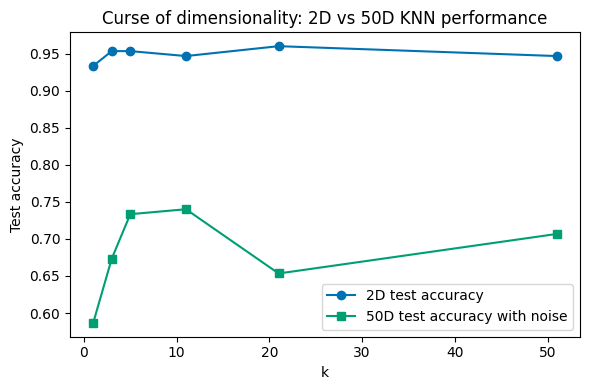

In [ ]:
def evaluate_knn_for_k(X_train, X_test, y_train, y_test, k_values):
    train_accs, test_accs = [], []
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        train_accs.append(model.score(X_train, y_train))
        test_accs.append(model.score(X_test, y_test))
    return train_accs, test_accs

k_values = [1, 3, 5, 11, 21, 51]

train_2d, test_2d = evaluate_knn_for_k(X_train, X_test, y_train, y_test, k_values)
train_50d, test_50d = evaluate_knn_for_k(Xh_train, Xh_test, yh_train, yh_test, k_values)

print("k values:", k_values)
print("2D test accuracies:", np.round(test_2d, 3))
print("50D test accuracies:", np.round(test_50d, 3))

plt.figure(figsize=(6, 4))
plt.plot(k_values, test_2d, marker="o", label="2D test accuracy")
plt.plot(k_values, test_50d, marker="s", label="50D test accuracy with noise")
plt.xlabel("k")
plt.ylabel("Test accuracy")
plt.title("Curse of dimensionality: 2D vs 50D KNN performance")
plt.legend()
plt.tight_layout()
plt.show()


When KNN is trained on the original two-dimensional features, the test accuracy stays high across different values of k, ranging from about 0.933 for `k = 1` to a peak of 0.960 for `k = 21`. In contrast, after adding 48 irrelevant noise dimensions (50D case), test accuracy drops substantially: for example, it is only 0.587 at `k = 1` and remains in the range 0.653–0.740 for the other k values, never approaching the 2D performance. This degradation illustrates the curse of dimensionality: in a high-dimensional space with many noisy features, distances between points become less informative for identifying truly similar neighbours, making a distance-based method like KNN much less effective.

### Distance concentration in high dimensions

**Nearest vs farthest distances**

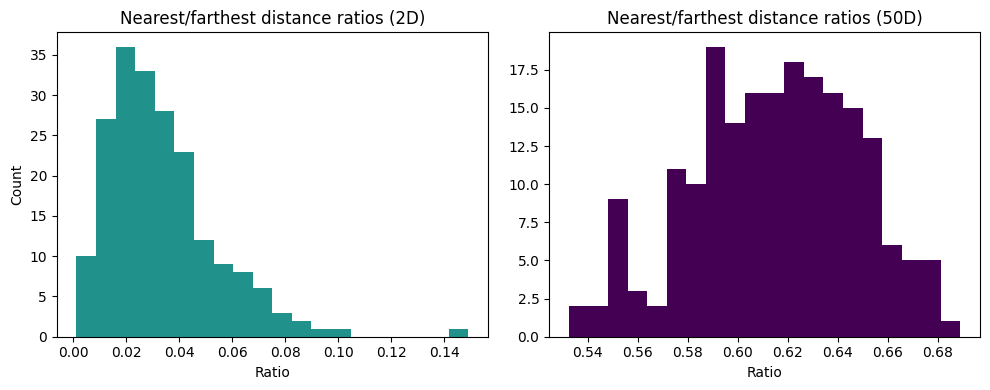

In [ ]:
from sklearn.metrics import pairwise_distances

def nearest_and_farthest_distances(X_sample, n_points=200, metric="euclidean"):
    X_sub = X_sample[:n_points]
    D = pairwise_distances(X_sub, metric=metric)
    D[D == 0] = np.nan  # ignore self-distances
    nearest = np.nanmin(D, axis=1)
    farthest = np.nanmax(D, axis=1)
    return nearest, farthest

nearest_2d, farthest_2d = nearest_and_farthest_distances(X_train)
nearest_50d, farthest_50d = nearest_and_farthest_distances(Xh_train)

ratio_2d = nearest_2d / farthest_2d
ratio_50d = nearest_50d / farthest_50d

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(ratio_2d, bins=20, color="#21918c")
plt.title("Nearest/farthest distance ratios (2D)")
plt.xlabel("Ratio")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(ratio_50d, bins=20, color="#440154")
plt.title("Nearest/farthest distance ratios (50D)")
plt.xlabel("Ratio")

plt.tight_layout()
plt.show()




The histograms of the ratio between each point’s nearest and farthest neighbour distances highlight how distances behave very differently in low and high dimensions.In 2D, most ratios are close to zero, meaning that the nearest neighbour is much closer than the farthest one, so the notion of “nearest” is meaningful. In 50D, the ratios are tightly concentrated around values between 0.55 and 0.65, indicating that nearest and farthest neighbours are at similar distances; this distance concentration is a core aspect of the curse of dimensionality and helps explain why KNN accuracy degrades when many noisy features are added.


## **Scaling and PCA**

**effect of scaling in 50D**

50D scaled test accuracies: [0.613 0.72  0.767 0.773 0.753 0.773]


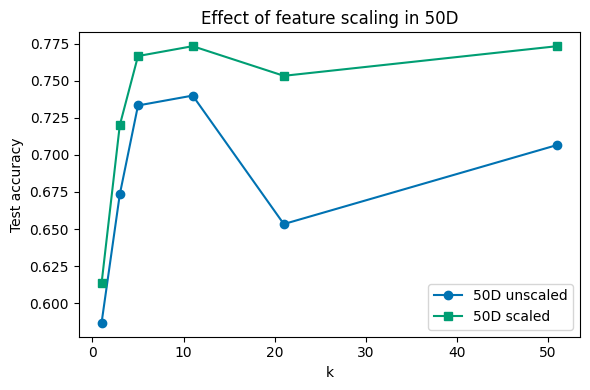

In [ ]:
# Standard scaling
scaler = StandardScaler()
Xh_train_scaled = scaler.fit_transform(Xh_train)
Xh_test_scaled = scaler.transform(Xh_test)

train_50d_scaled, test_50d_scaled = evaluate_knn_for_k(
    Xh_train_scaled, Xh_test_scaled, yh_train, yh_test, k_values
)

print("50D scaled test accuracies:", np.round(test_50d_scaled, 3))

plt.figure(figsize=(6, 4))
plt.plot(k_values, test_50d, marker="o", label="50D unscaled")
plt.plot(k_values, test_50d_scaled, marker="s", label="50D scaled")
plt.xlabel("k")
plt.ylabel("Test accuracy")
plt.title("Effect of feature scaling in 50D")
plt.legend()
plt.tight_layout()
plt.show()


### Mitigation 1: feature scaling in high dimensions

Applying standardisation to all 50 features noticeably improves KNN performance in the high-dimensional setting. Without scaling, test accuracy ranges from about 0.587 to 0.740 across the tested k values, whereas after scaling it increases to values between 0.613 and 0.773, with the best result of 0.773 achieved around `k = 11` or `k = 51`.Because KNN relies directly on distance computations, bringing all features onto a similar scale prevents noisy dimensions with larger variance from dominating the distance and helps the algorithm focus more evenly on the informative structure in the data.

**PCA as dimensionality reduction**

PCA (2D) test accuracies: [0.567 0.6   0.613 0.667 0.673 0.66 ]


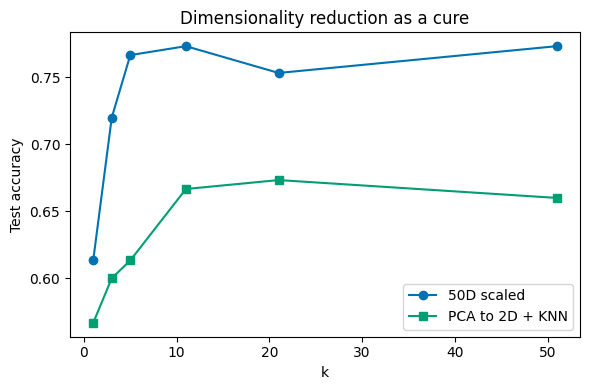

In [ ]:
# PCA to 2D after scaling
pca = PCA(n_components=2, random_state=42)
Xh_train_pca = pca.fit_transform(Xh_train_scaled)
Xh_test_pca = pca.transform(Xh_test_scaled)

train_pca, test_pca = evaluate_knn_for_k(
    Xh_train_pca, Xh_test_pca, yh_train, yh_test, k_values
)

print("PCA (2D) test accuracies:", np.round(test_pca, 3))

plt.figure(figsize=(6, 4))
plt.plot(k_values, test_50d_scaled, marker="o", label="50D scaled")
plt.plot(k_values, test_pca, marker="s", label="PCA to 2D + KNN")
plt.xlabel("k")
plt.ylabel("Test accuracy")
plt.title("Dimensionality reduction as a cure")
plt.legend()
plt.tight_layout()
plt.show()


### Mitigation 2: dimensionality reduction with PCA

Projecting the scaled 50-dimensional data down to two principal components using PCA before applying KNN gives test accuracies between 0.567 and 0.673 across the chosen k values.Although this PCA-based KNN does not reach the best scaled-50D performance, it consistently outperforms the original unscaled 50D model and recovers much of the lost accuracy while operating in a far lower-dimensional space. This supports the idea that dimensionality reduction can partially counteract the curse of dimensionality by discarding noisy directions and concentrating information in a smaller number of more meaningful components.
